## Multiscale HiTS

### created by Yuying Liu, 05/07/2020

This script is a template for benchmarking multiscale HiTS against single time-scale neural network time-steppers. We find multiscale HiTS can provide the most accurate forecasts with good efficiency. 

With the help of this script, one can reproduce:
- Figure 5
- Table 5

In [154]:
import os
import sys
import time
import torch
import numpy as np
import scipy.interpolate
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import ResNet as net

In [155]:
# adjustables
dt = 0.01                     # time unit: 0.0005 for Lorenz and 0.01 for others
system = 'KS_new'         # system name: 'Hyperbolic', 'Cubic', 'VanDerPol', 'Hopf' or 'Lorenz'

In [334]:
# path
data_dir = os.path.join('../../data/', system)
model_dir = os.path.join('../../models/', system)

# global const
# ks = [1]#list(range(11))
# step_sizes = [2**k for k in ks]
step_sizes = [4,  8, 216]
letter = 'b'
noise = 0.0

### load data & models

In [335]:
# load validation set and test set
# val_data = np.load(os.path.join(data_dir, 'val_noise0.0.npy'))
# test_data = np.load(os.path.join(data_dir, 'test_noise0.0.npy'))
# train_data = np.load(os.path.join(data_dir, 'train_noise0.0.npy'))
train_data = np.load(os.path.join(data_dir, 'train_long_noise0.0.npy'))
test_data = train_data[:10]
val_data = train_data

In [336]:
train_data.shape

(100, 1090, 512)

In [337]:
# load models
models = list()
for step_size in step_sizes:
#     try:
#     print('load model_D{}.pt'.format(step_size))
    model_name = 'original_model_D{}_noise{}.pt'.format(step_size, noise, letter)
    print("load ", model_name)
#     original_model_D1_noise0.0
    try:
        models.append(torch.load(os.path.join(model_dir, model_name), map_location='cpu'))
    except:
        model_name = 'original_model_D{}_noise{}_{}.pt'.format(step_size, noise, letter)
        models.append(torch.load(os.path.join(model_dir, model_name), map_location='cpu'))
#     except:
#         print("problem")
#         pass

# fix model consistencies trained on gpus (optional)
for model in models:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()

load  original_model_D4_noise0.0.pt
load  original_model_D8_noise0.0.pt
load  original_model_D216_noise0.0.pt


In [338]:
print(len(models))

3


### benchmarks

In [339]:
# shared info
n_steps = test_data.shape[1] - 1
t = [dt*(step+1) for step in range(n_steps)]
criterion = torch.nn.MSELoss(reduction='none')

In [340]:
 def uni_scale_forecast(self, x_init, n_steps):
        """
        :param x_init: array of shape n_test x input_dim
        :param n_steps: number of steps forward in terms of dt
        :return: predictions of shape n_test x n_steps x input_dim and the steps
        """
        steps = list()
        preds = list()
        sample_steps = range(n_steps)

        # forward predictions
        x_prev = x_init
        cur_step = self.step_size - 1
        while cur_step < n_steps + self.step_size:
            x_next = self.forward(x_prev)
            steps.append(cur_step)
            preds.append(x_next)
            cur_step += self.step_size
            x_prev = x_next

        # include the initial frame
        steps.insert(0, 0)
        print(x_init[0])
        preds.insert(0, torch.tensor(x_init).float().to(self.device))
        
        print(preds[0][0])

        # interpolations
        preds = torch.stack(preds, 2).detach().numpy()
        cs = scipy.interpolate.interp1d(steps, preds, kind='linear')
        y_preds = torch.tensor(cs(sample_steps)).transpose(1, 2).float()
        print(y_preds[0,0])

        return y_preds

In [341]:
y_preds = uni_scale_forecast(models[0], torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)

tensor([-1.0169e+00, -9.3711e-01, -8.3211e-01, -7.0436e-01, -5.5640e-01,
        -3.9075e-01, -2.0993e-01, -1.6471e-02,  1.8691e-01,  3.9719e-01,
         6.1081e-01,  8.2347e-01,  1.0300e+00,  1.2241e+00,  1.3986e+00,
         1.5452e+00,  1.6553e+00,  1.7199e+00,  1.7311e+00,  1.6822e+00,
         1.5693e+00,  1.3917e+00,  1.1530e+00,  8.6113e-01,  5.2835e-01,
         1.7026e-01, -1.9530e-01, -5.4987e-01, -8.7607e-01, -1.1591e+00,
        -1.3880e+00, -1.5560e+00, -1.6610e+00, -1.7050e+00, -1.6931e+00,
        -1.6332e+00, -1.5343e+00, -1.4061e+00, -1.2582e+00, -1.0995e+00,
        -9.3788e-01, -7.7990e-01, -6.3099e-01, -4.9530e-01, -3.7575e-01,
        -2.7421e-01, -1.9151e-01, -1.2760e-01, -8.1574e-02, -5.1834e-02,
        -3.6127e-02, -3.1674e-02, -3.5281e-02, -4.3461e-02, -5.2569e-02,
        -5.8943e-02, -5.9041e-02, -4.9567e-02, -2.7597e-02,  9.3240e-03,
         6.3091e-02,  1.3496e-01,  2.2548e-01,  3.3443e-01,  4.6073e-01,
         6.0237e-01,  7.5635e-01,  9.1855e-01,  1.0

/tmp/ipykernel_562/594025710.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))


tensor([-1.0169e+00, -9.3711e-01, -8.3211e-01, -7.0436e-01, -5.5640e-01,
        -3.9075e-01, -2.0993e-01, -1.6471e-02,  1.8691e-01,  3.9719e-01,
         6.1081e-01,  8.2347e-01,  1.0300e+00,  1.2241e+00,  1.3986e+00,
         1.5452e+00,  1.6553e+00,  1.7199e+00,  1.7311e+00,  1.6822e+00,
         1.5693e+00,  1.3917e+00,  1.1530e+00,  8.6113e-01,  5.2835e-01,
         1.7026e-01, -1.9530e-01, -5.4987e-01, -8.7607e-01, -1.1591e+00,
        -1.3880e+00, -1.5560e+00, -1.6610e+00, -1.7050e+00, -1.6931e+00,
        -1.6332e+00, -1.5343e+00, -1.4061e+00, -1.2582e+00, -1.0995e+00,
        -9.3788e-01, -7.7990e-01, -6.3099e-01, -4.9530e-01, -3.7575e-01,
        -2.7421e-01, -1.9151e-01, -1.2760e-01, -8.1574e-02, -5.1834e-02,
        -3.6127e-02, -3.1674e-02, -3.5281e-02, -4.3461e-02, -5.2569e-02,
        -5.8943e-02, -5.9041e-02, -4.9567e-02, -2.7597e-02,  9.3240e-03,
         6.3091e-02,  1.3496e-01,  2.2548e-01,  3.3443e-01,  4.6073e-01,
         6.0237e-01,  7.5635e-01,  9.1855e-01,  1.0

(-3.0, 3.0)

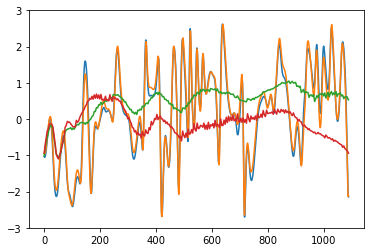

In [342]:
plt.plot(test_data[0,1:,0])
plt.plot(test_data[0,1:,1])
plt.plot(y_preds[0,:,0])
plt.plot(y_preds[0,:,1])
plt.ylim([-3,3])
# plt.show()



  0%|          | 0/3 [00:00<?, ?it/s]

/mnt/c/Users/16kat/OneDrive - acornonsite.com/multiscale_Time_depends/src/ResNet.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))


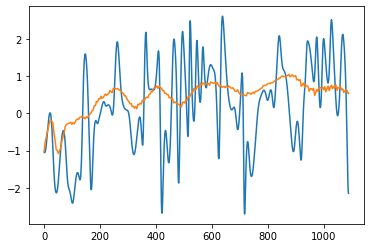

/mnt/c/Users/16kat/OneDrive - acornonsite.com/multiscale_Time_depends/src/ResNet.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))


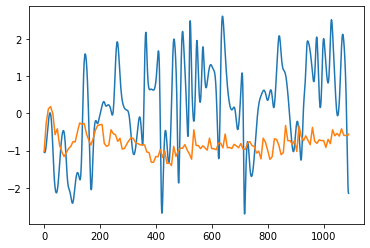

/mnt/c/Users/16kat/OneDrive - acornonsite.com/multiscale_Time_depends/src/ResNet.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))


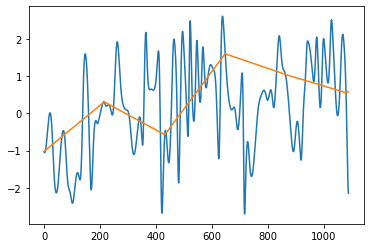

(array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

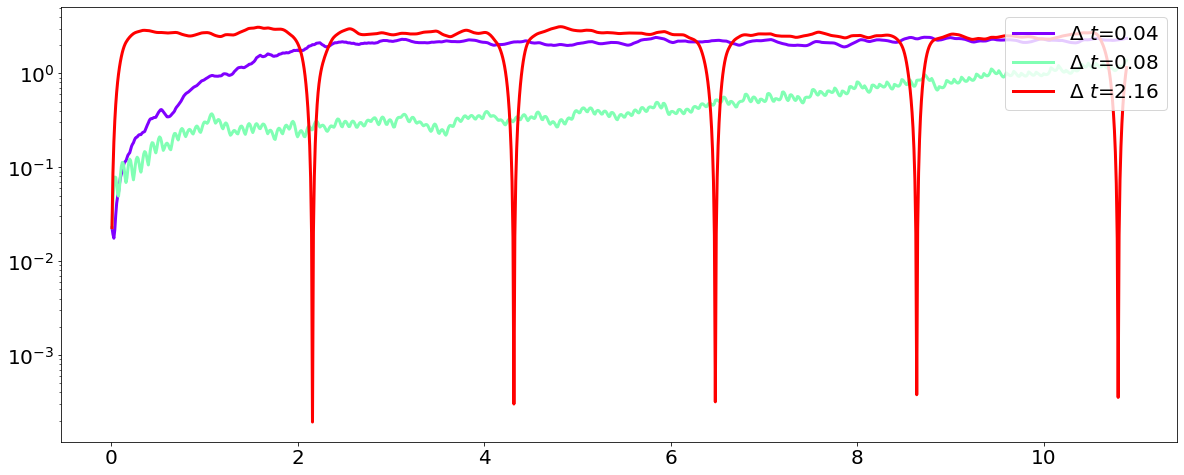

In [343]:
# uniscale time-stepping with NN
preds_mse = list()
times = list()

for model in tqdm(models):
    start = time.time()
    y_preds = model.uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
    
    end = time.time()
    times.append(end - start)
    preds_mse.append(criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean(-1))
    
    plt.plot(test_data[0, 1:, 0])
    plt.plot(y_preds[0,:,0])
    plt.show()
    
# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(preds_mse))))
for k in range(len(preds_mse)):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.semilogy(t, mean, linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}'.format(step_sizes[k]*dt))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

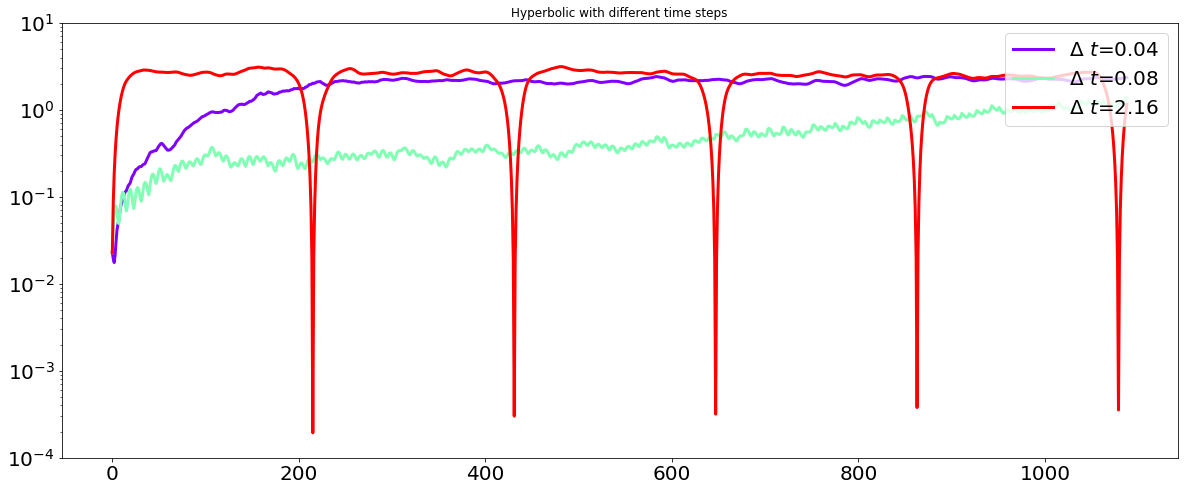

In [344]:
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(preds_mse))))
for k in range(len(preds_mse)):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.semilogy(mean, linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}'.format(step_sizes[k]*dt))
# plt.xlim([0,100])
plt.ylim([0.0001, 10])
plt.title("Hyperbolic with different time steps")
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [345]:
def vectorized_multi_scale_forecast(x_init, n_steps, models):
    """
    :param x_init: initial state torch array of shape n_test x n_dim
    :param n_steps: number of steps forward in terms of dt
    :param models: a list of models
    :return: a torch array of size n_test x n_steps x n_dim,
             a list of indices that are not achieved by interpolations
    """
    # sort models by their step sizes (decreasing order)
    step_sizes = [model.step_size for model in models]
    models = [model for _, model in sorted(zip(step_sizes, models), reverse=True)]

    # we assume models are sorted by their step sizes (decreasing order)
    n_test, n_dim = x_init.shape
    device = 'cpu'#'cuda' if torch.cuda.is_available() else 'cpu'
    indices = list()
    extended_n_steps = n_steps + models[0].step_size + 1
    print("models[0].step_size = ", models[0].step_size)
    preds = torch.zeros(n_test, extended_n_steps + 1, n_dim).float().to(device)
    print("preds shape = ", preds.shape)

    # vectorized simulation
    indices.append(0)
    preds[:, 0, :] = x_init
    total_step_sizes = n_steps
    for model in models:
        print("model.step_size = ", model.step_size)
        n_forward = int(total_step_sizes/model.step_size)
        y_prev = preds[:, indices, :].reshape(-1, n_dim)
        indices_lists = [indices]
        for t in range(n_forward):
            y_next = model(y_prev)
            print("y_next shape = ", y_next.shape)
            shifted_indices = np.array([x + (t + 1) * model.step_size for x in indices])
            print("extended_n_steps =", extended_n_steps)
            print("indices = ", indices)
            print("shifted_indices", shifted_indices)
            shifted_indices = shifted_indices[np.array(shifted_indices) < extended_n_steps]  
            
            indices_lists.append(shifted_indices)
            
            print("y_next.reshape(n_test, -1, n_dim) shape = ", y_next.reshape(n_test, -1, n_dim).shape)
            print("preds[:, shifted_indices, :] shape = ", preds[:, shifted_indices, :].shape)
            preds[:, shifted_indices, :] = y_next.reshape(n_test, -1, n_dim)[:, :len(shifted_indices)]
            
            y_prev = y_next
        indices = [val for tup in zip(*indices_lists) for val in tup]
        total_step_sizes = model.step_size - 1

    # simulate the tails
    last_idx = indices[-1]
    y_prev = preds[:, last_idx, :]
    while last_idx < n_steps:
        last_idx += models[-1].step_size
        y_next = models[-1](y_prev)
        preds[:, last_idx, :] = y_next
        indices.append(last_idx)
        y_prev = y_next

    # interpolations
    sample_steps = range(1, n_steps+1)
    valid_preds = preds[:, indices, :].detach().numpy()
    cs = scipy.interpolate.interp1d(indices, valid_preds, kind='linear', axis=1)
    y_preds = torch.tensor(cs(sample_steps)).float()

    return y_preds

models[0].step_size =  216
preds shape =  torch.Size([10, 1307, 512])
model.step_size =  216
y_next shape =  torch.Size([10, 512])
extended_n_steps = 1306
indices =  [0]
shifted_indices [216]
y_next.reshape(n_test, -1, n_dim) shape =  torch.Size([10, 1, 512])
preds[:, shifted_indices, :] shape =  torch.Size([10, 1, 512])
y_next shape =  torch.Size([10, 512])
extended_n_steps = 1306
indices =  [0]
shifted_indices [432]
y_next.reshape(n_test, -1, n_dim) shape =  torch.Size([10, 1, 512])
preds[:, shifted_indices, :] shape =  torch.Size([10, 1, 512])
y_next shape =  torch.Size([10, 512])
extended_n_steps = 1306
indices =  [0]
shifted_indices [648]
y_next.reshape(n_test, -1, n_dim) shape =  torch.Size([10, 1, 512])
preds[:, shifted_indices, :] shape =  torch.Size([10, 1, 512])
y_next shape =  torch.Size([10, 512])
extended_n_steps = 1306
indices =  [0]
shifted_indices [864]
y_next.reshape(n_test, -1, n_dim) shape =  torch.Size([10, 1, 512])
preds[:, shifted_indices, :] shape =  torch.Size([

0
1
2


(0.001, 10)

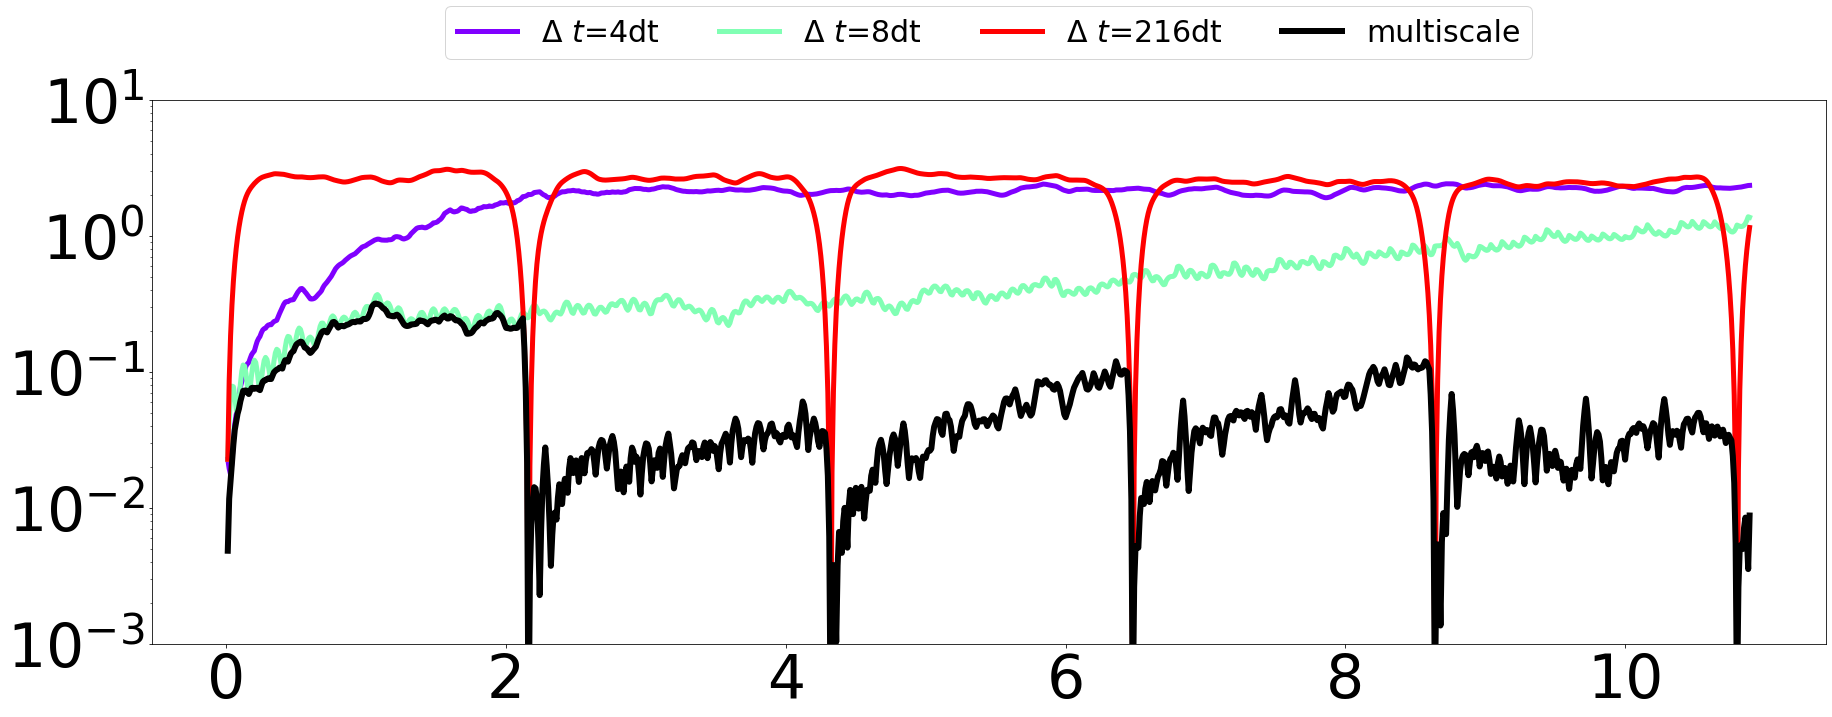

In [346]:
# multiscale time-stepping with NN
start = time.time()
# y_preds = net.vectorized_multi_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps, models=models)
y_preds = vectorized_multi_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps, models=models)
end = time.time()
multiscale_time = end - start
multiscale_preds_mse = criterion(torch.tensor(test_data[:, 1:, :]).float(), y_preds).mean(-1)

# visualize forecasting error at each time step    
fig = plt.figure(figsize=(30, 10))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(preds_mse))))
multiscale_err = multiscale_preds_mse.mean(0).detach().numpy()
for k in range(len(preds_mse)):
    print(k)
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.semilogy(t, mean, linestyle='-', color=rgb, linewidth=5, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
plt.semilogy(t, multiscale_err, linestyle='-', color='k', linewidth=6, label='multiscale')
plt.legend(fontsize=30, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.2))
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)

plt.ylim([0.001, 10])

In [331]:
torch.tensor(test_data[:, 0, :]).float().shape

torch.Size([10, 512])

(-3.0, 3.0)

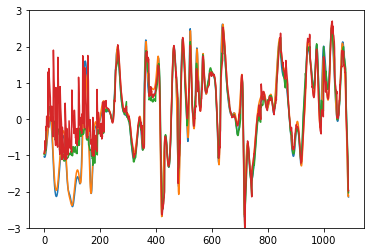

In [332]:
plt.plot(test_data[0,1:,0])
plt.plot(test_data[0,1:,1])
plt.plot(y_preds[0,:,0])
plt.plot(y_preds[0,:,1])
plt.ylim([-3,3])
# plt.show()

Text(0.5, 1.0, 'Truth')

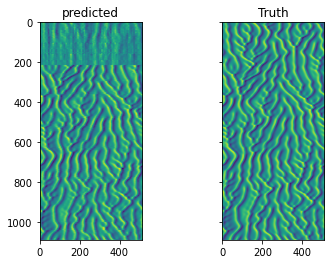

In [333]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(y_preds[0], vmin = np.min(test_data[0]), vmax = np.max(test_data[0]))
ax1.set_title('predicted')
# plt.colorbar()
# plt.show()
ax2.imshow(test_data[0], vmin = np.min(test_data[0]), vmax = np.max(test_data[0]))
ax2.set_title('Truth')
# ax2.colorbar()

In [ ]:
# integration of a sampled test trial 
# (you need to change the code here accordingly as state variables are different for different systems)
idx = 5
t = np.linspace(0, (n_steps-1)*dt, n_steps)
fig = plt.figure(figsize=(30, 10))
gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])
ax0.plot(t, test_data[idx, 0:n_steps, 0], 'r-', linewidth=10, label='x')
ax0.plot(t, test_data[idx, 0:n_steps, 1], 'b-', linewidth=10, label='y')
# ax0.plot(t, test_data[idx, 0:n_steps, 2], 'g-', linewidth=10, label='z')
ax0.plot(t, y_preds[idx, 0:n_steps, 0].detach().numpy(), 'k--', linewidth=10, label='learned')
ax0.plot(t, y_preds[idx, 0:n_steps, 1].detach().numpy(), 'k--', linewidth=10)
# ax0.plot(t, y_preds[idx, 0:n_steps, 2].detach().numpy(), 'k--', linewidth=10)
ax0.legend(fontsize=50, loc='upper right')
ax0.tick_params(axis='both', which='major', labelsize=60)

In [ ]:
# computation time
for i in range(len(times)):
    print('single scaled model (Dt={}): computing time {}s'.format(step_sizes[i]*dt, times[i]))
print('ensembled multiscale model: computing time {}s'.format(multiscale_time))

In [69]:
import random
all_combos = np.load('all_combos_'+str(1)+'.npy', allow_pickle=True)
print(all_combos)
# all_combos = all_combos - 1

def predict_random_combo(models, test_data=test_data, timesteps = 5000, to_plot=True):

    step_sizes = [4, 8, 16]
    t = 0
    
#     idx_combo = random.sample(range(len(all_combos)), 1)
#     path = all_combos[idx_combo[0]]
#     print(path)
    
#     steps_per_combo = sum(path)

#     path_loops = timesteps // steps_per_combo - 1
    
#     print("path_loops = ", path_loops)
#     n_timepoints = path_loops * len(path)
#     print("n_steps = ", n_timepoints)
    
    n_test_points, _, ndim = test_data.shape


    t_list = list()
    y_pred_list = list()#np.zeros((n_test_points, n_timepoints, ndim))

#     this_step_size = path[0]
#     t+= this_step_size*4
#     y_preds = models[this_step_size-1].forward(torch.tensor(test_data[:, 0]).float())
    y_preds = torch.tensor(test_data[:, 0]).float()
#     y_pred_list[:,0] = y_preds.detach().numpy()
#     t_list[0] = t
#     print(y_preds.shape)

#     for j in range(n_timepoints-1):
    while t < timesteps:
        this_pick = np.random.randint(0,3)
        this_step_size = step_sizes[this_pick]#path[j%len(path)]
        t+= this_step_size
        y_preds = models[this_pick].forward(y_preds)

        y_pred_list.append(y_preds.detach().numpy())
        t_list.append(t)
        
    t_list = np.array(t_list)
    y_pred_list = np.array(y_pred_list)
    
    print("y_pred_list shape = ", y_pred_list.shape)
    print(" test_data[:,t_list.astype(int)] shape = ",  test_data[:,t_list.astype(int)].shape)
    print("max t = ", max(t_list))
    if to_plot:
        plt.plot(t_list, y_pred_list[0,:,0])
        plt.plot(t_list, test_data[0,t_list.astype(int), 0])
        plt.title("step_size = " + str(step_size)+ ": noise = "+ str(noise))
        plt.show()
    
    mse = np.mean((y_pred_list - test_data[:,t_list.astype(int)])**2, axis = (0,2))
    if to_plot:
        plt.semilogy(t_list, mse)
        plt.title("step_size = " + str(step_size)+ ": noise = "+ str(noise))
        plt.show()
    
    return y_pred_list, mse, t_list, path

num_lines = 1
mse_list = list()
t_list_list = list()
path_list = list()
y_pred_list = list()

for i in range(num_lines):
    y_preds_random, mse_random, t_list_random, path_random = predict_random_combo(models, to_plot = False,  timesteps = 1000)#timesteps-(smallest_step*4))
    y_pred_list.append(y_preds_random[0,:])
    mse_list.append(mse_random)
    t_list_list.append(t_list_random)
    path_list.append(path_random)

[(1, 1) (2,) (1, 1, 1) ... (4, 4, 2, 4, 1) (4, 4, 4, 1, 2) (4, 4, 4, 2, 1)]
y_pred_list shape =  (113, 320, 2)
 test_data[:,t_list.astype(int)] shape =  (320, 113, 2)
max t =  1000


ValueError: operands could not be broadcast together with shapes (113,320,2) (320,113,2) 

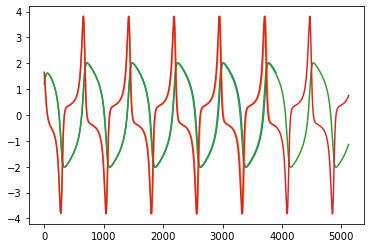

In [40]:
plt.plot(t_list_random, y_preds_random[0])
plt.plot(test_data[0])

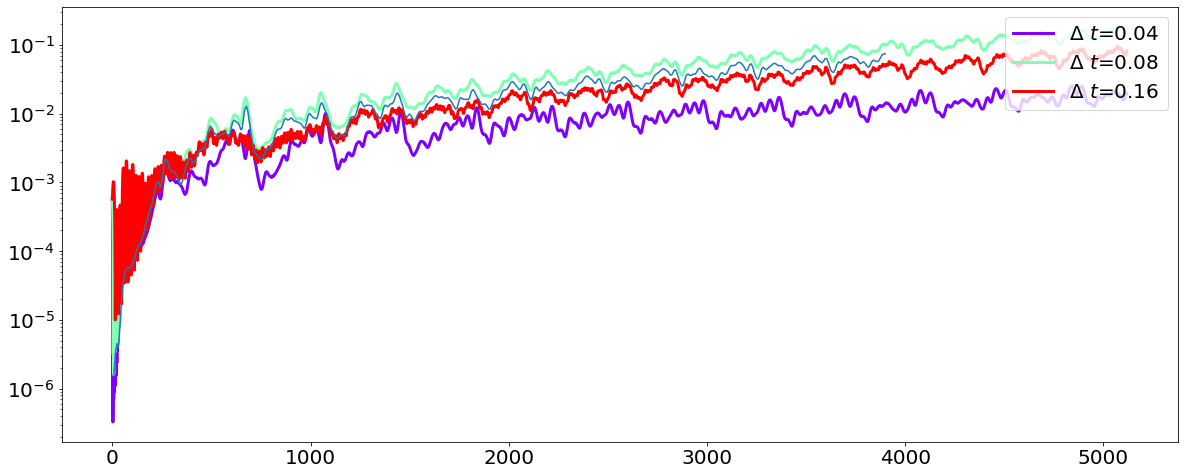

In [56]:
# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(preds_mse))))
for k in range(len(preds_mse)):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.semilogy(mean, linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}'.format(step_sizes[k]*dt))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.semilogy(t_list_list[0],mse_list[0])
plt.show()

In [46]:
len(mse_list)

1